# 將 CH8-量化系統擇時.ipynb 的單股回測系統優化
1. 將一些需要用到的 BaseClass 跟 Implement 搬過來
2. 實作多股回測系統，加入風險控制類別

In [ ]:
import setup_path  # 設定 Python 路徑以引用 alanq 模組
from alanq.positions import (
    FixedRatioPositionManager,
    RiskBasedPositionManager,
    EqualWeightPositionManager,
    VolatilityBasedPositionManager,
    FixedKellyPositionManager
)
from alanq.backtest import MultiStockBacktester
from alanq.data import StockDataManager
from alanq.factors import BreakoutBuyFactor, BreakdownSellFactor, AtrStopSellFactor
from alanq.performance import PerformanceMetrics

In [2]:
# =========================================================
# 多股票回測範例
# =========================================================
symbols_to_download = ["TSLA", "AAPL", "MSFT"]
start_date = "2020-01-01"
data_manager = StockDataManager(symbols_to_download, start_date=start_date)

stock_data = data_manager.get_stock_data()

print(f"已下載 {len(stock_data)} 檔股票資料")
for symbol, df in stock_data.items():
    print(f"{symbol}: {len(df)} 筆資料，日期範圍 {df.index[0]} 至 {df.index[-1]}")


正在使用 yfinance 下載 3 檔股票資料...
------------------------------
已成功下載 3 檔股票資料
  - TSLA: 1482 筆資料，日期範圍 2020-01-02 至 2025-11-21
  - AAPL: 1482 筆資料，日期範圍 2020-01-02 至 2025-11-21
  - MSFT: 1482 筆資料，日期範圍 2020-01-02 至 2025-11-21
------------------------------
已下載 3 檔股票資料
TSLA: 1482 筆資料，日期範圍 2020-01-02 00:00:00 至 2025-11-21 00:00:00
AAPL: 1482 筆資料，日期範圍 2020-01-02 00:00:00 至 2025-11-21 00:00:00
MSFT: 1482 筆資料，日期範圍 2020-01-02 00:00:00 至 2025-11-21 00:00:00


範例 1：固定比例倉位管理（預設）


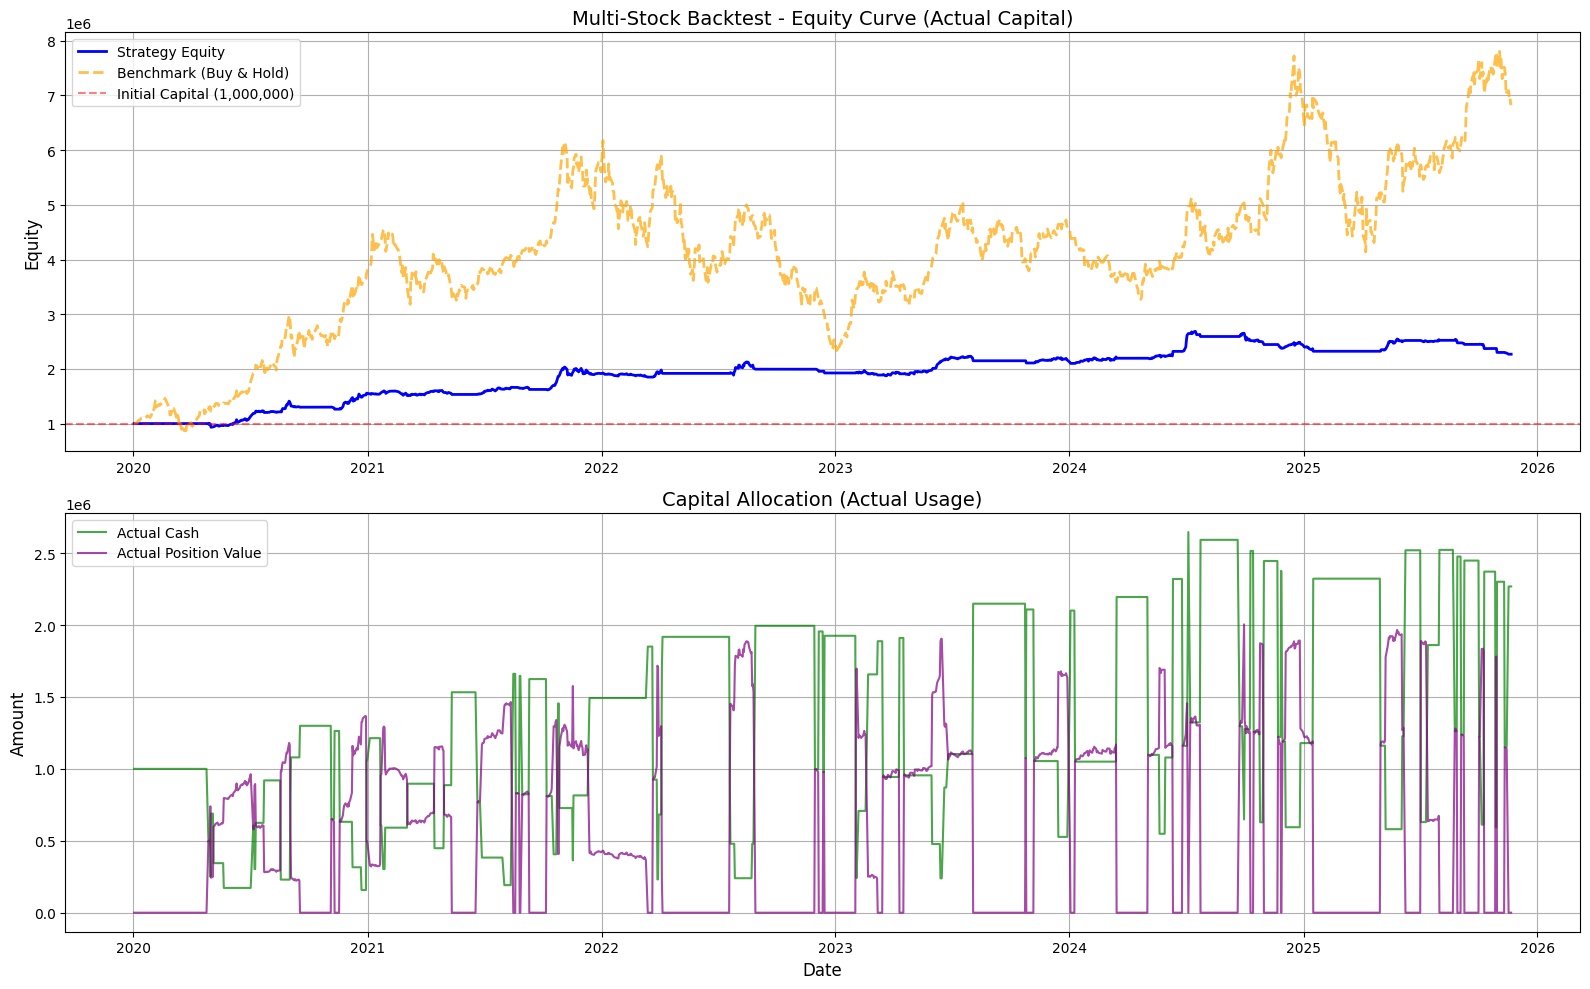

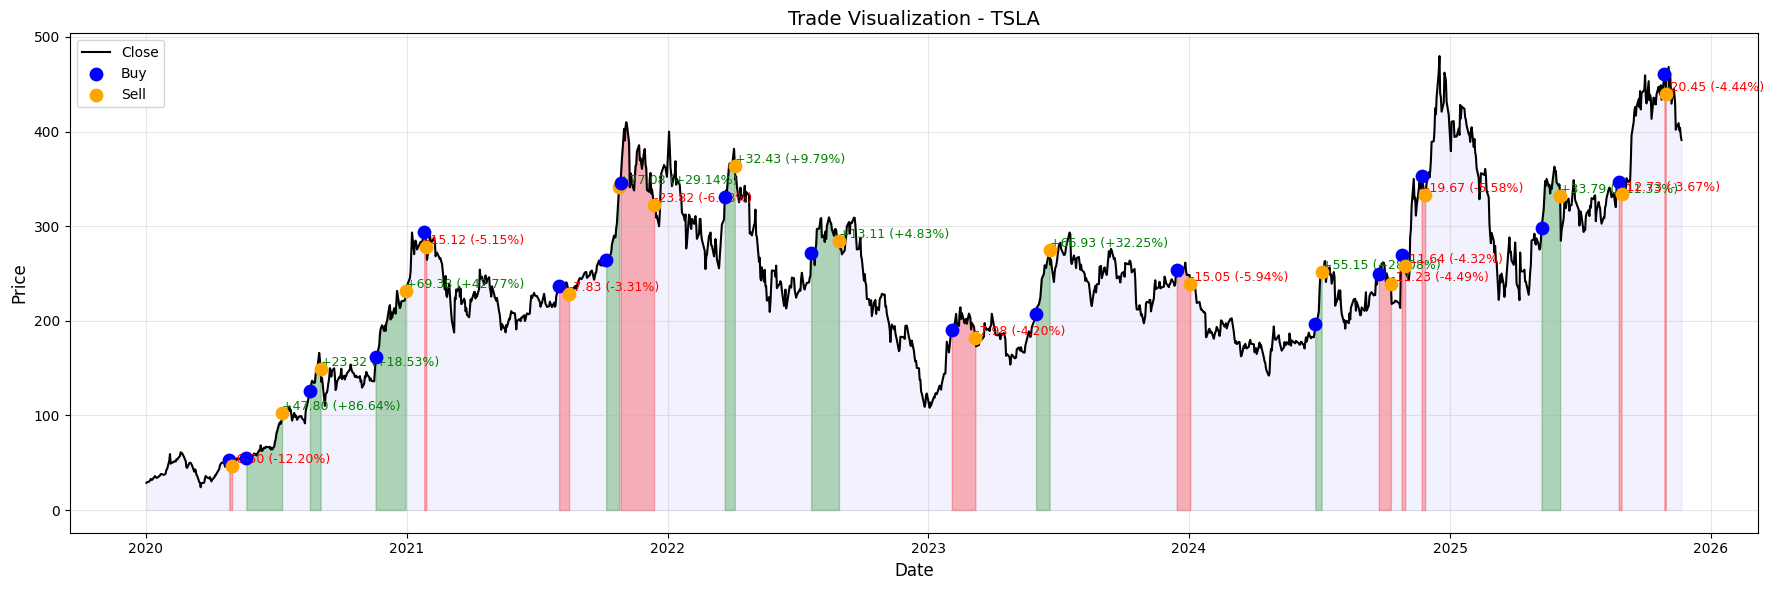

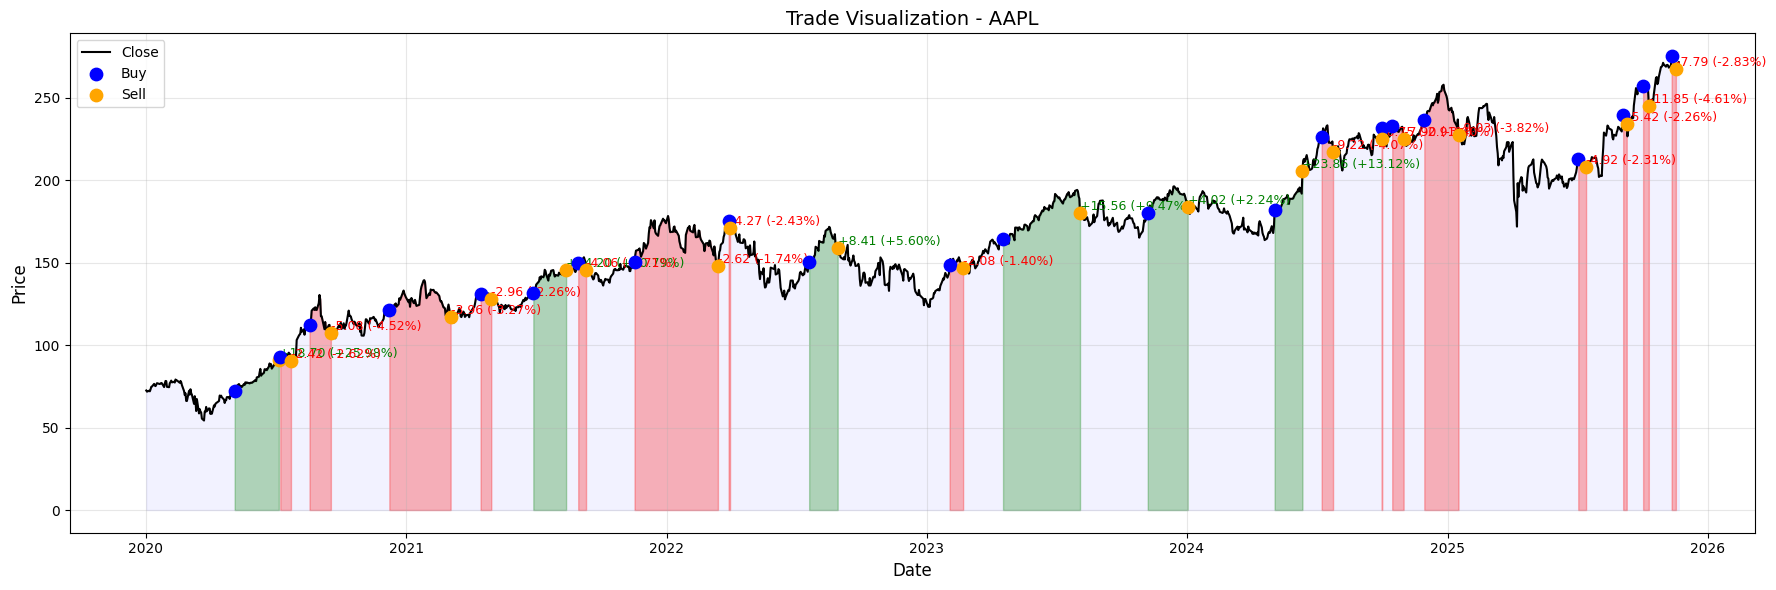

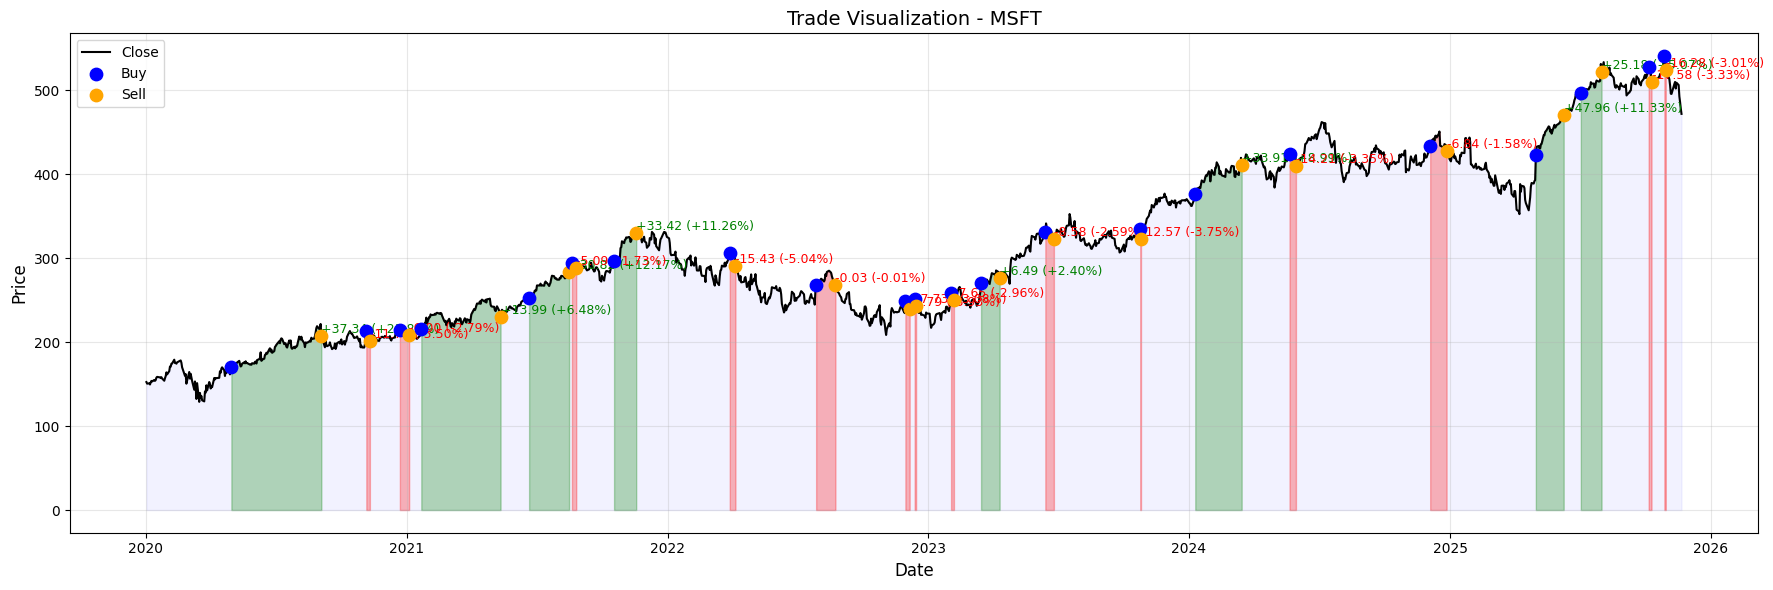


=== 績效指標 ===
策略_總報酬率: 1.2684
策略_年化報酬率: 0.1492
策略_年化波動率: 0.1312
策略_Sharpe: 1.1281
策略_最大回撤: -0.1558
策略_最終權益: 2268388.7311
策略_實際最終現金: 2268388.7311
基準_總報酬率: 5.8255
基準_年化報酬率: 0.3855
基準_Sharpe: 0.6835
基準_最大回撤: -0.6238

=== 交易紀錄（前 10 筆） ===
  symbol entry_date  exit_date  entry_price  exit_price       shares  \
0   TSLA 2020-04-27 2020-05-01    53.250000   46.754665  9389.671362   
1   TSLA 2020-05-21 2020-07-10    55.173332  102.976669  3122.028863   
2   TSLA 2020-08-18 2020-09-02   125.806000  149.123337  3655.675442   
3   TSLA 2020-11-18 2020-12-30   162.213333  231.593338  3895.010915   
4   TSLA 2021-01-25 2021-01-28   293.600006  278.476654  1033.345932   
5   TSLA 2021-08-02 2021-08-16   236.556671  228.723328   809.900138   
6   TSLA 2021-10-07 2021-10-25   264.536682  341.619995  3070.073753   
7   TSLA 2021-10-27 2021-12-13   345.953339  322.136658  2102.699960   
8   TSLA 2022-03-22 2022-04-05   331.326660  363.753326  2792.182272   
9   TSLA 2022-07-21 2022-08-29   271.706665  

In [3]:

# 範例 1：使用固定比例倉位管理（預設）
print("=" * 60)
print("範例 1：固定比例倉位管理（預設）")
print("=" * 60)

buy_factors = [
    {"class": BreakoutBuyFactor, "xd": 60},
    {"class": BreakoutBuyFactor, "xd": 42},
]

sell_factors = [
    {"class": BreakdownSellFactor, "xd": 120},
    {"class": AtrStopSellFactor, "stop_loss_n": 0.5, "stop_win_n": 3.0}
]

# 使用預設的固定比例倉位管理（50%）
bt1 = MultiStockBacktester(
    stock_data=stock_data,
    buy_factors=buy_factors,
    sell_factors=sell_factors,
    initial_capital=1_000_000,
    enable_full_rate_factor=False
)

results1, trades1, stats1 = bt1.run(show_plot=True, show_trades_plot=True)

print("\n=== 績效指標 ===")
for k, v in stats1.items():
    if isinstance(v, float):
        print(f"{k}: {v:.4f}")
    else:
        print(f"{k}: {v:,.0f}")

print(f"\n=== 交易紀錄（前 10 筆） ===")
print(trades1.head(10))

print(f"\n總交易次數: {len(trades1)}")
print(f"各股票交易次數:")
print(trades1.groupby('symbol').size())


In [4]:
stats1

{'策略_總報酬率': np.float64(1.268388731125456),
 '策略_年化報酬率': np.float64(0.1491831428883268),
 '策略_年化波動率': np.float64(0.13116256372955556),
 '策略_Sharpe': np.float64(1.12810004196008),
 '策略_最大回撤': np.float64(-0.15579086509509077),
 '策略_最終權益': np.float64(2268388.731125456),
 '策略_實際最終現金': np.float64(2268388.731125456),
 '基準_總報酬率': np.float64(5.825504346904085),
 '基準_年化報酬率': np.float64(0.38550763151804923),
 '基準_Sharpe': np.float64(0.6835174587216722),
 '基準_最大回撤': np.float64(-0.6237812205807979)}

範例 2：基於風險的倉位管理


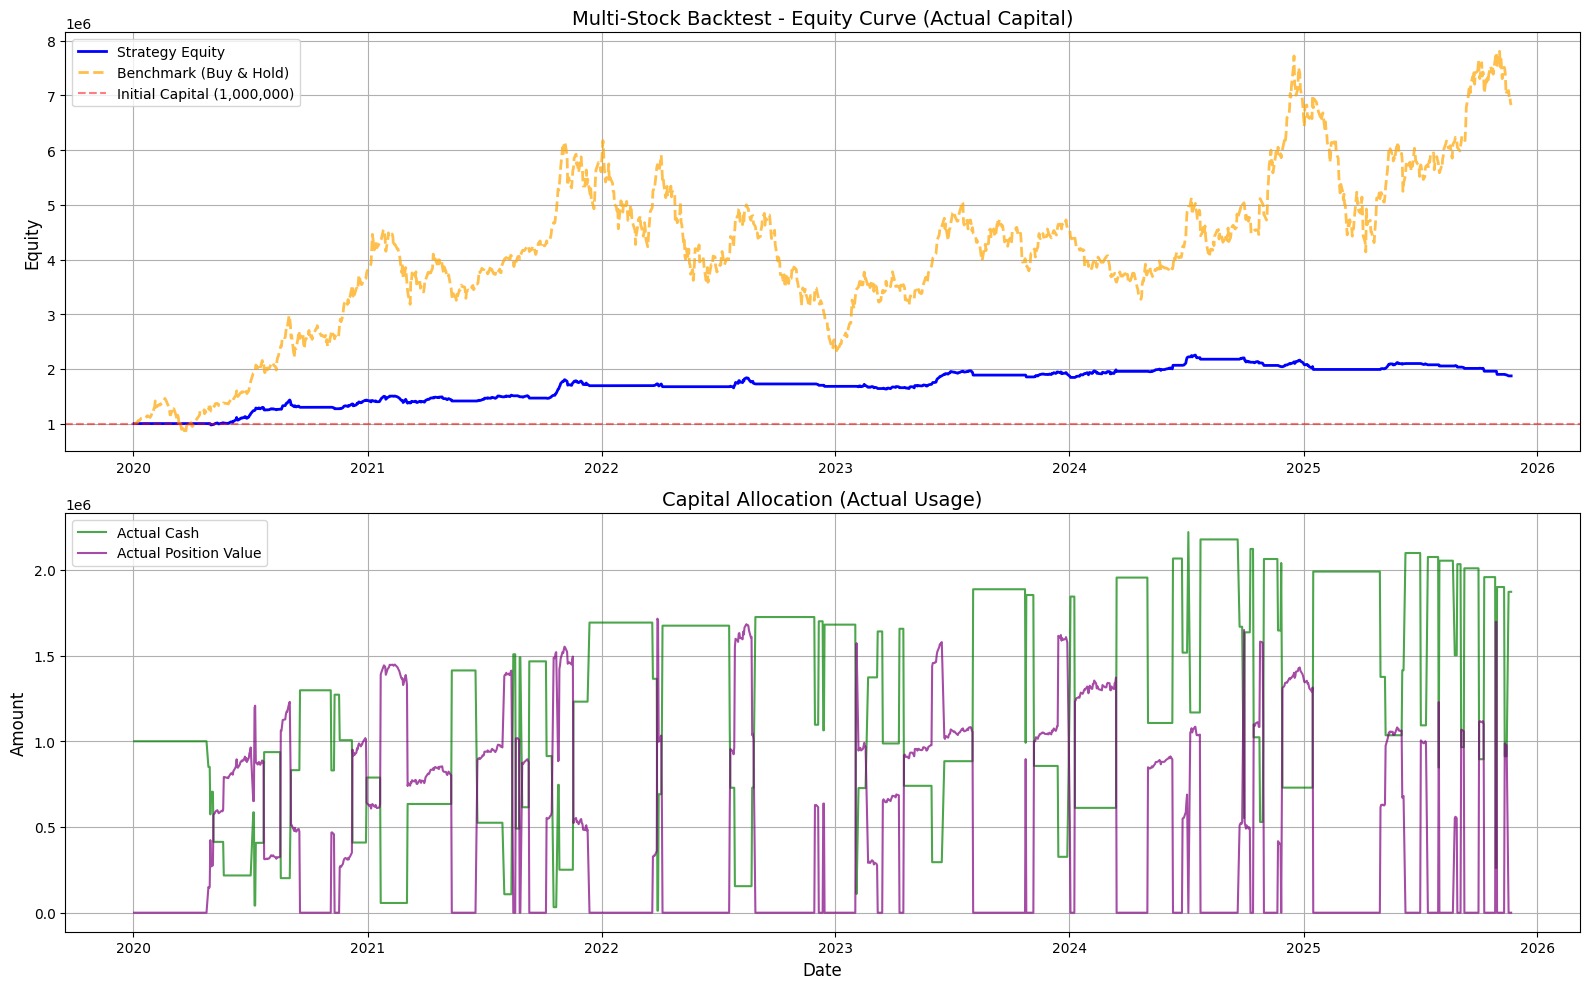

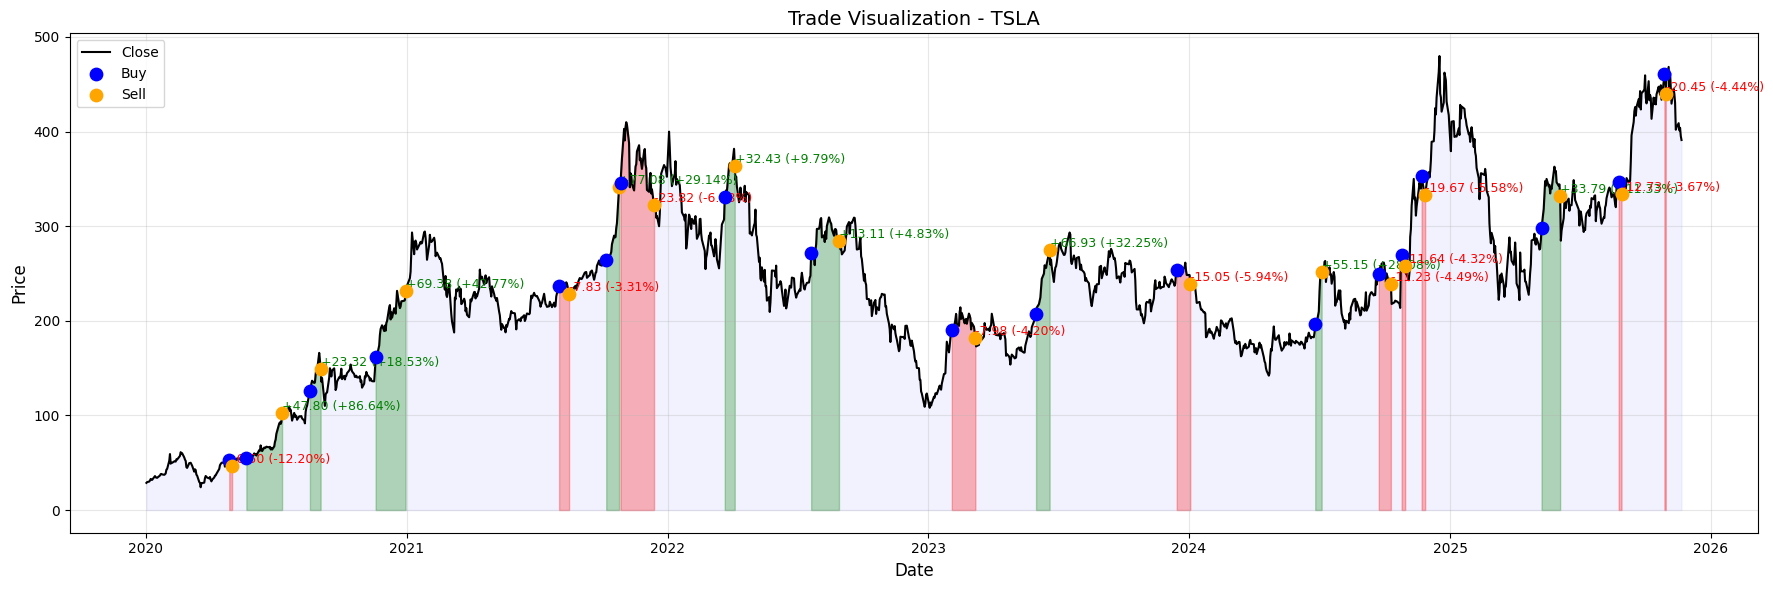

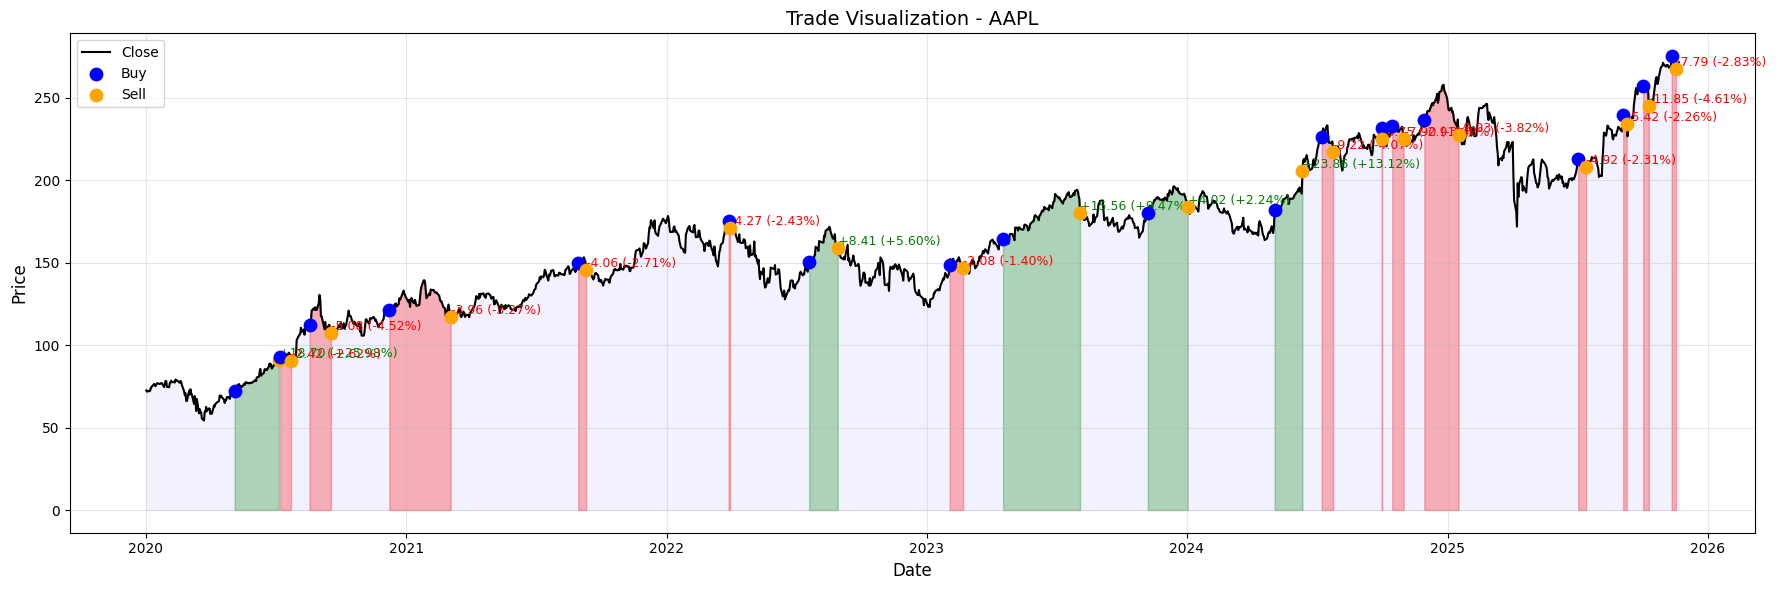

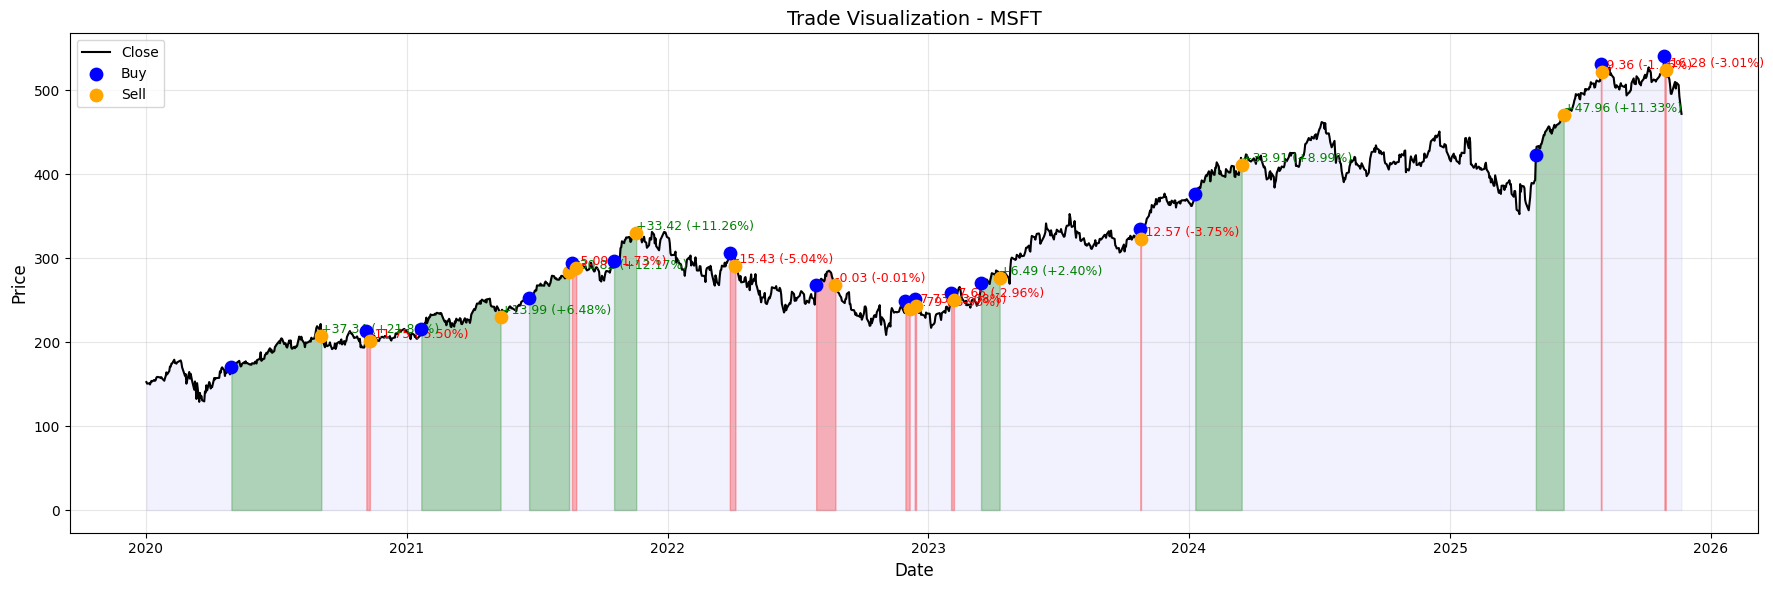


=== 績效指標 ===
策略_總報酬率: 0.8718
策略_年化報酬率: 0.1123
策略_年化波動率: 0.1141
策略_Sharpe: 0.9917
策略_最大回撤: -0.1690
策略_最終權益: 1871791.1541
策略_實際最終現金: 1871791.1541
基準_總報酬率: 5.8255
基準_年化報酬率: 0.3855
基準_Sharpe: 0.6835
基準_最大回撤: -0.6238

總交易次數: 55


In [5]:
# 範例 2：使用基於風險的倉位管理
print("=" * 60)
print("範例 2：基於風險的倉位管理")
print("=" * 60)

# 建立基於風險的倉位管理器
risk_position_manager = RiskBasedPositionManager(
    risk_per_trade=0.02,  # 每筆交易風險 2%
    atr_multiplier=2.0,   # ATR 倍數
    max_position_ratio=1.0  # 最大持倉比例 100%
)

bt2 = MultiStockBacktester(
    stock_data=stock_data,
    buy_factors=buy_factors,
    sell_factors=sell_factors,
    initial_capital=1_000_000,
    position_manager=risk_position_manager,  # 傳入自訂倉位管理器
    enable_full_rate_factor=False
)

results2, trades2, stats2 = bt2.run(show_plot=True, show_trades_plot=True)

print("\n=== 績效指標 ===")
for k, v in stats2.items():
    if isinstance(v, float):
        print(f"{k}: {v:.4f}")
    else:
        print(f"{k}: {v:,.0f}")

print(f"\n總交易次數: {len(trades2)}")


範例 3：等權重倉位管理


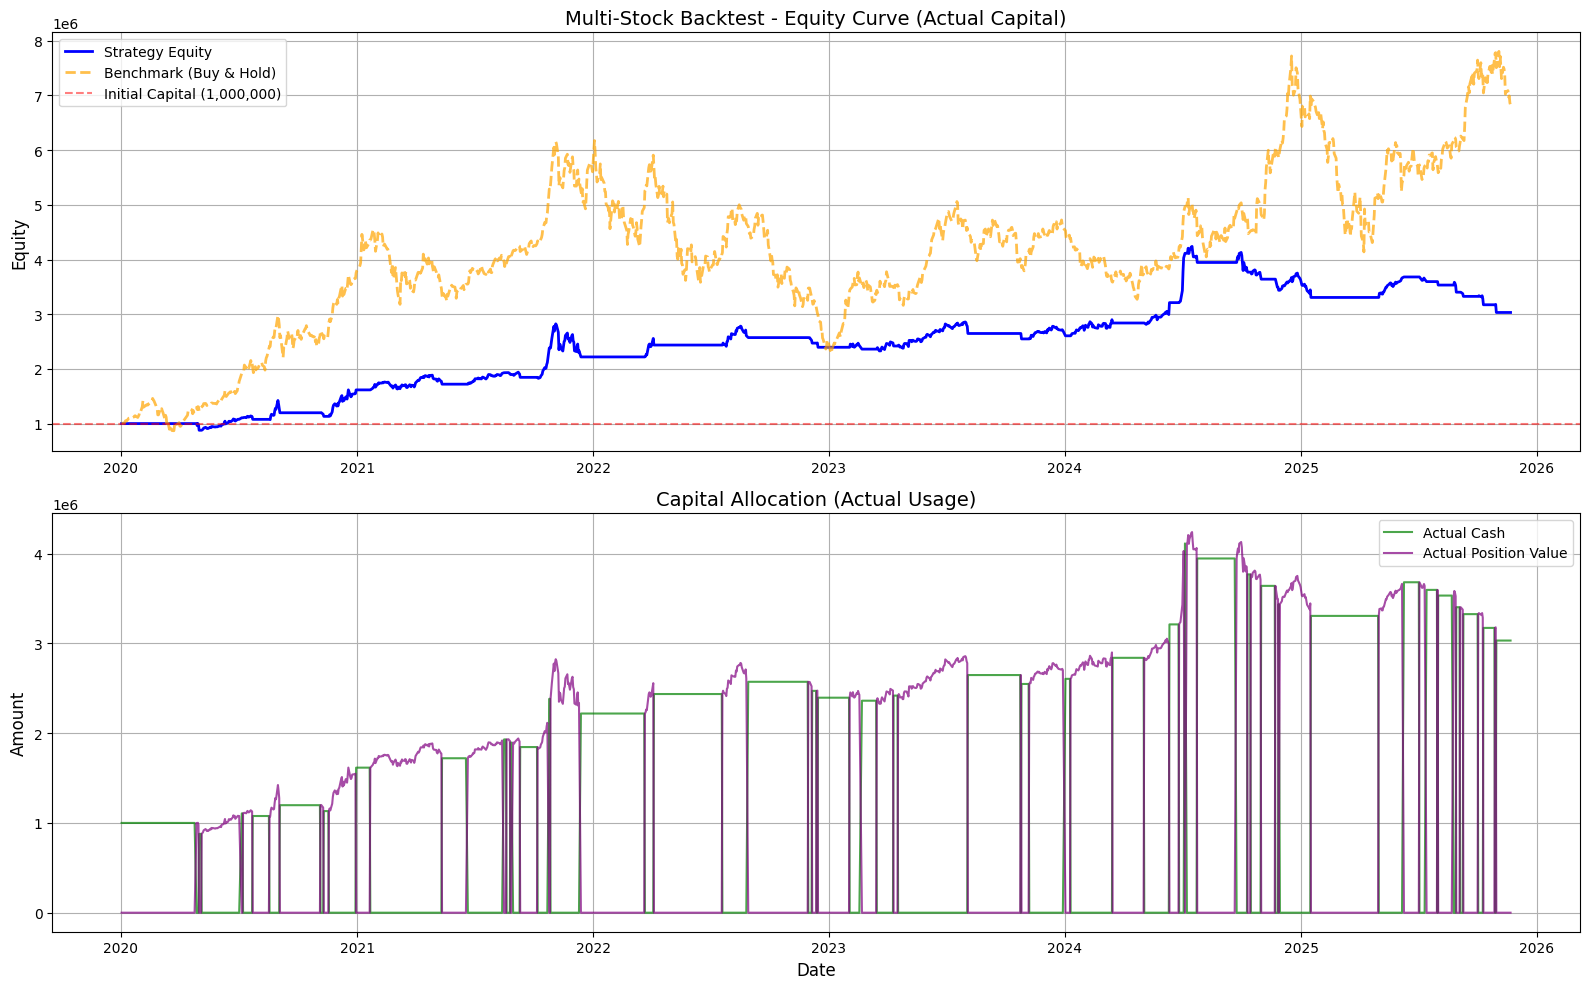

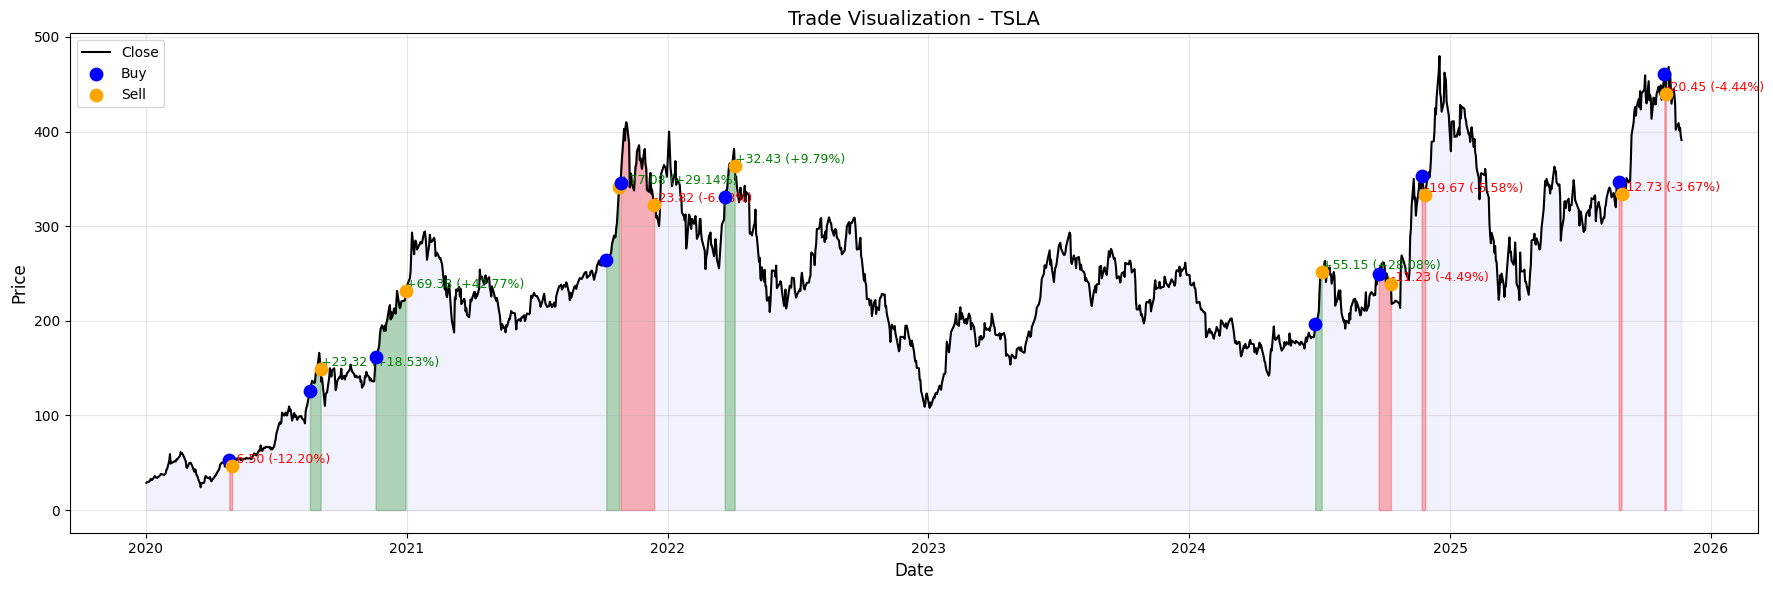

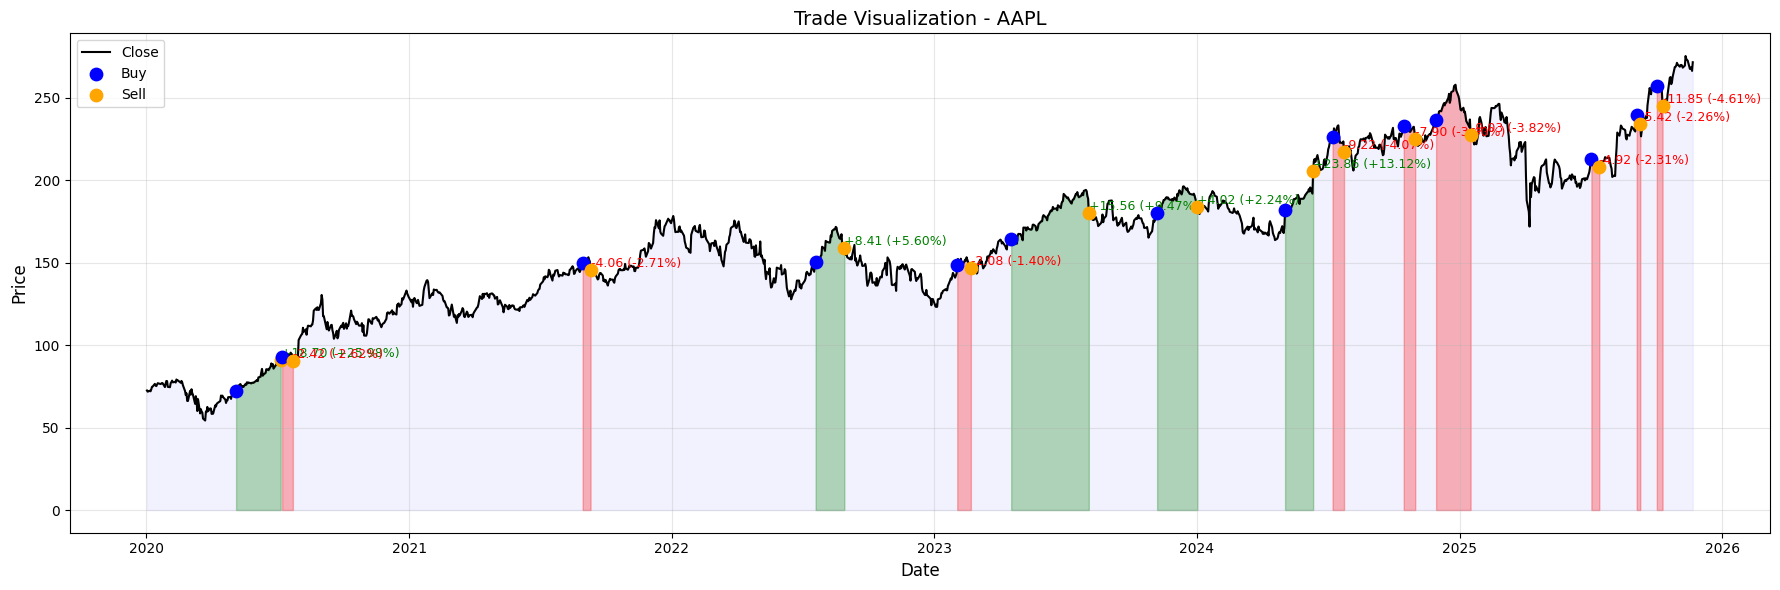

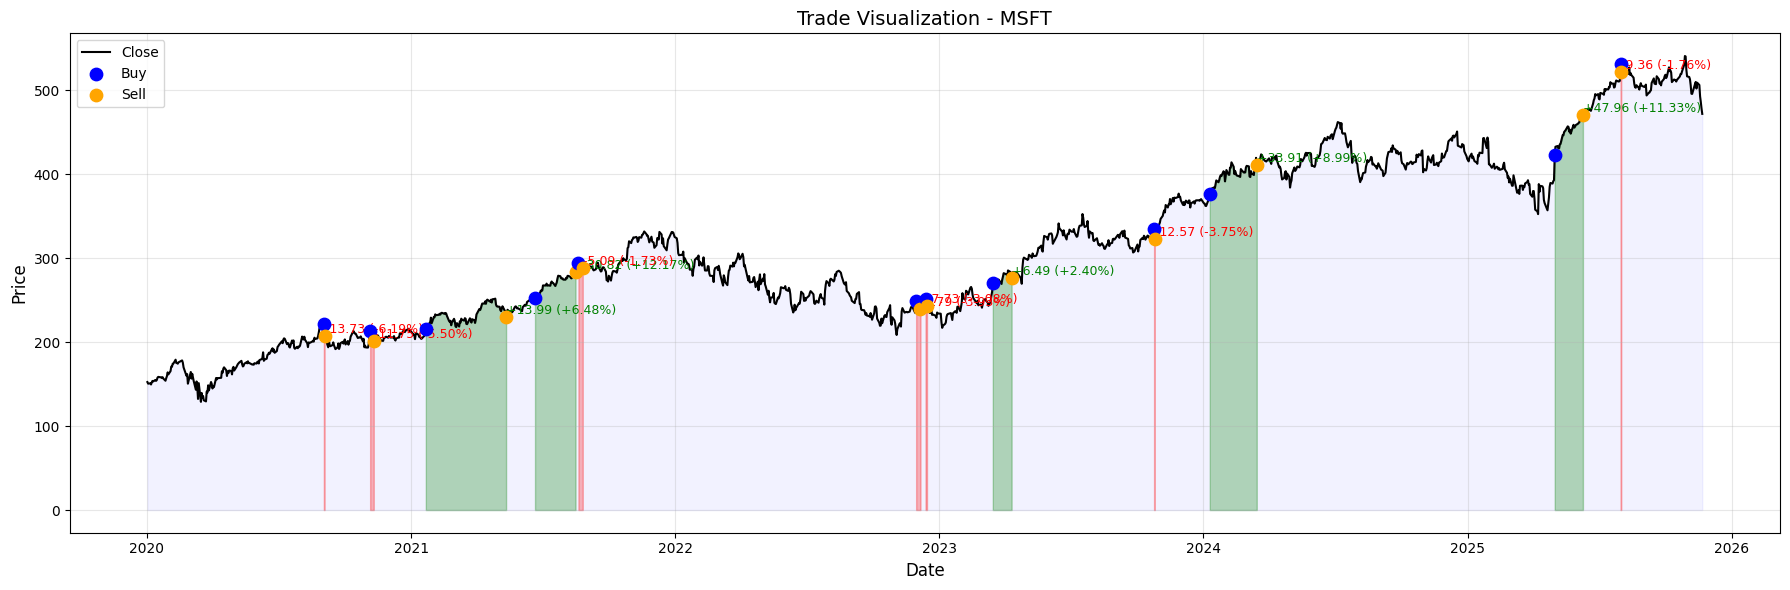


=== 績效指標 ===
策略_總報酬率: 2.0319
策略_年化報酬率: 0.2072
策略_年化波動率: 0.2320
策略_Sharpe: 0.9289
策略_最大回撤: -0.2850
策略_最終權益: 3031925.4963
策略_實際最終現金: 3031925.4963
基準_總報酬率: 5.8255
基準_年化報酬率: 0.3855
基準_Sharpe: 0.6835
基準_最大回撤: -0.6238

總交易次數: 37

各股票交易次數:
symbol
AAPL    14
MSFT    12
TSLA    11
dtype: int64


In [6]:
# 範例 3：使用等權重倉位管理
print("=" * 60)
print("範例 3：等權重倉位管理")
print("=" * 60)

# 建立等權重倉位管理器
equal_weight_manager = EqualWeightPositionManager(
    max_stocks=3  # 最多同時持有 3 檔股票
)

bt3 = MultiStockBacktester(
    stock_data=stock_data,
    buy_factors=buy_factors,
    sell_factors=sell_factors,
    initial_capital=1_000_000,
    position_manager=equal_weight_manager,
    enable_full_rate_factor=False
)

results3, trades3, stats3 = bt3.run(show_plot=True, show_trades_plot=True)

print("\n=== 績效指標 ===")
for k, v in stats3.items():
    if isinstance(v, float):
        print(f"{k}: {v:.4f}")
    else:
        print(f"{k}: {v:,.0f}")

print(f"\n總交易次數: {len(trades3)}")
print(f"\n各股票交易次數:")
print(trades3.groupby('symbol').size())


範例：使用 Fixed Kelly 倉位管理
--- Fixed Kelly PM Initialized ---
Win Rate (p): 0.5500, Odds Ratio (r): 1.2000
Calculated Kelly Ratio (f): 0.0875
----------------------------------


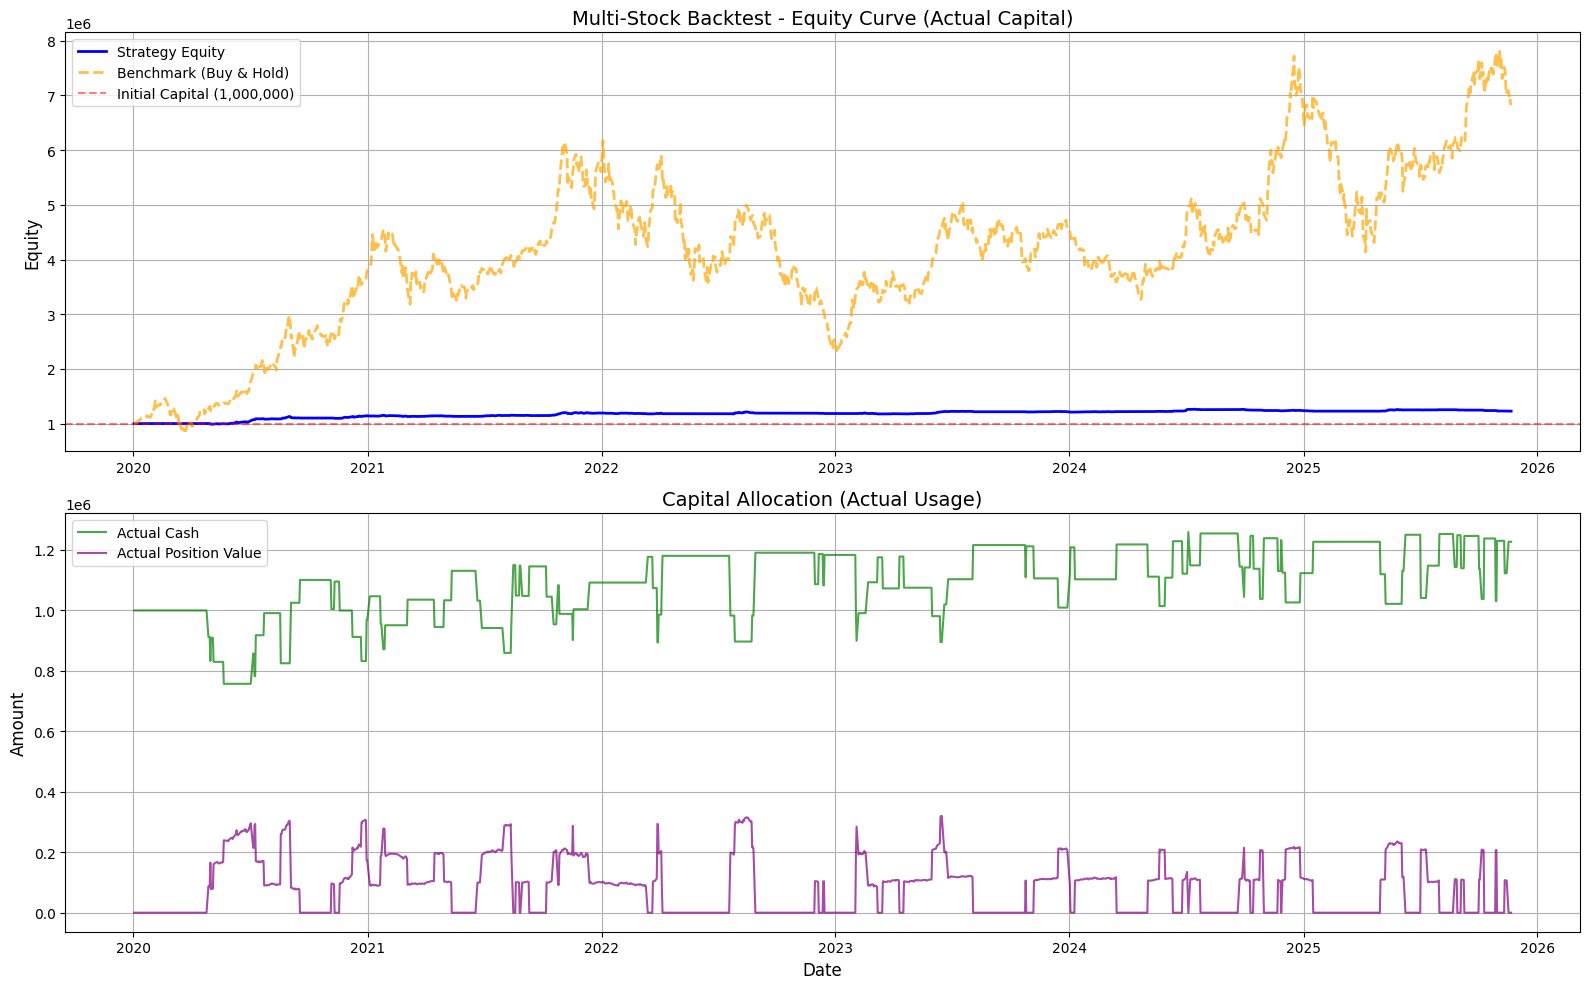


=== 績效指標 ===
策略_總報酬率: 0.2273
策略_年化報酬率: 0.0354
策略_年化波動率: 0.0326
策略_Sharpe: 1.0860
策略_最大回撤: -0.0317
策略_最終權益: 1227306.4323
策略_實際最終現金: 1227306.4323
基準_總報酬率: 5.8255
基準_年化報酬率: 0.3855
基準_Sharpe: 0.6835
基準_最大回撤: -0.6238

總交易次數: 64

各股票交易次數:
symbol
AAPL    22
MSFT    22
TSLA    20
dtype: int64


In [7]:
# 範例 4：Kelly公式的倉位管理

print("=" * 60)
print("範例：使用 Fixed Kelly 倉位管理")
print("=" * 60)

# 1. 建立 Fixed Kelly 倉位管理器
# 假設策略的預估參數為 p=0.55, r=1.2 (約產生 4.5% 的 Kelly 比例)
fixed_kelly_manager = FixedKellyPositionManager(
    win_rate=0.55, 
    odds_ratio=1.2, 
    full_kelly_ratio=0.5,  # 使用保守的半 Kelly 投入 (50%)
    max_position_ratio=1.0 # 最大倉位 100%
)

# FixedKellyPositionManager 在初始化時會打印計算出的 Kelly 比例

bt_kelly = MultiStockBacktester(
    stock_data=stock_data,
    buy_factors=buy_factors,
    sell_factors=sell_factors,
    initial_capital=1_000_000,
    position_manager=fixed_kelly_manager,
    enable_full_rate_factor=False
)

# 執行回測並繪圖
# 假設 bt_kelly.run() 會返回 results, trades, stats
results_kelly, trades_kelly, stats_kelly = bt_kelly.run(show_plot=True)

print("\n=== 績效指標 ===")
for k, v in stats_kelly.items():
    if isinstance(v, float):
        print(f"{k}: {v:.4f}")
    else:
        print(f"{k}: {v:,.0f}")

print(f"\n總交易次數: {len(trades_kelly)}")
print(f"\n各股票交易次數:")
print(trades_kelly.groupby('symbol').size())

範例 4：比較不同倉位管理策略
--- Fixed Kelly PM Initialized ---
Win Rate (p): 0.5500, Odds Ratio (r): 1.2000
Calculated Kelly Ratio (f): 0.0875
----------------------------------

=== 倉位管理策略比較 ===
           策略名稱   策略總報酬率  策略年化報酬率  策略Sharpe    策略最大回撤  策略交易次數       策略最終權益   基準總報酬率  基準年化報酬率  基準Sharpe    基準最大回撤
fix ratio (50%) 0.682498 0.092345  0.445045 -0.508777      64 1.682498e+06 5.825504 0.385508  0.683517 -0.623781
fix ratio (30%) 1.220084 0.144991  0.648415 -0.374807      64 2.220084e+06 5.825504 0.385508  0.683517 -0.623781
     risk based 1.328050 0.154259  0.750681 -0.268270      55 2.328050e+06 5.825504 0.385508  0.683517 -0.623781
   equal weight 2.031925 0.207202  0.928890 -0.284976      37 3.031925e+06 5.825504 0.385508  0.683517 -0.623781
    Fixed Kelly 1.566378 0.173517  0.774222 -0.298612      64 2.566378e+06 5.825504 0.385508  0.683517 -0.623781


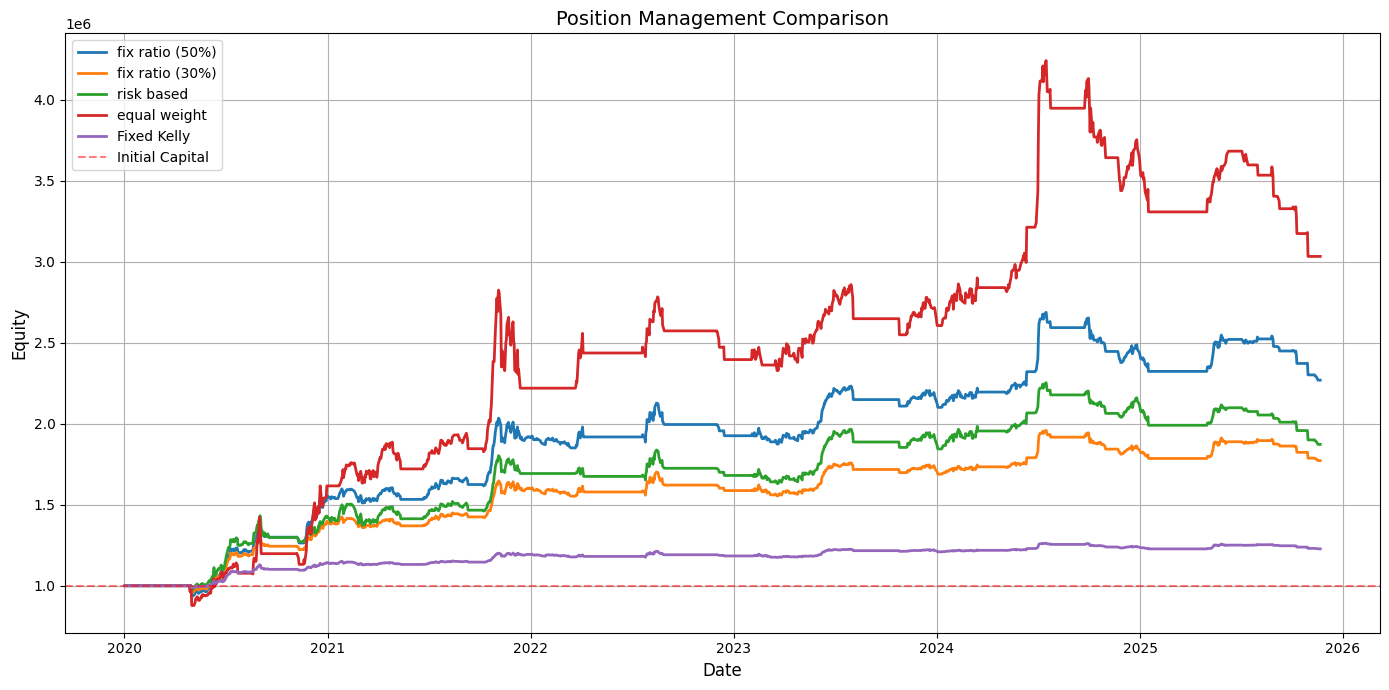

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

# 範例 5：比較不同倉位管理策略
print("=" * 60)
print("範例 4：比較不同倉位管理策略")
print("=" * 60)

# 定義不同的倉位管理策略
position_managers = {
    "fix ratio (50%)": FixedRatioPositionManager(position_ratio=0.5),
    "fix ratio (30%)": FixedRatioPositionManager(position_ratio=0.3),
    "risk based": RiskBasedPositionManager(risk_per_trade=0.02, atr_multiplier=2.0),
    "equal weight": EqualWeightPositionManager(max_stocks=3),
    "Fixed Kelly": FixedKellyPositionManager(win_rate=0.55, odds_ratio=1.2, full_kelly_ratio=0.5, max_position_ratio=1.0)
}

comparison_results = []

for name, pm in position_managers.items():
    bt = MultiStockBacktester(
        stock_data=stock_data,
        buy_factors=buy_factors,
        sell_factors=sell_factors,
        initial_capital=1_000_000,
        position_manager=pm,
        enable_full_rate_factor=True
    )
    
    results, trades, stats = bt.run(show_plot=False)
    
    comparison_results.append({
        "策略名稱": name,
        "策略總報酬率": stats["策略_總報酬率"],
        "策略年化報酬率": stats["策略_年化報酬率"],
        "策略Sharpe": stats["策略_Sharpe"],
        "策略最大回撤": stats["策略_最大回撤"],
        "策略交易次數": len(trades),
        "策略最終權益": stats["策略_最終權益"],
        "基準總報酬率": stats["基準_總報酬率"],
        "基準年化報酬率": stats["基準_年化報酬率"],
        "基準Sharpe": stats["基準_Sharpe"],
        "基準最大回撤": stats["基準_最大回撤"],
    })

comparison_df = pd.DataFrame(comparison_results)
print("\n=== 倉位管理策略比較 ===")
print(comparison_df.to_string(index=False))

# 繪製權益曲線比較
fig, ax = plt.subplots(figsize=(14, 7))

for name, pm in position_managers.items():
    bt = MultiStockBacktester(
        stock_data=stock_data,
        buy_factors=buy_factors,
        sell_factors=sell_factors,
        initial_capital=1_000_000,
        position_manager=pm
    )
    results, trades, stats = bt.run(show_plot=False)
    ax.plot(results['equity_curve'].index, 
            results['equity_curve'].values, 
            label=name, linewidth=2)

ax.axhline(y=1_000_000, color='r', linestyle='--', alpha=0.5, label='Initial Capital')
ax.set_title('Position Management Comparison', fontsize=14)
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Equity', fontsize=12)
ax.legend()
ax.grid(True)
plt.tight_layout()
plt.show()


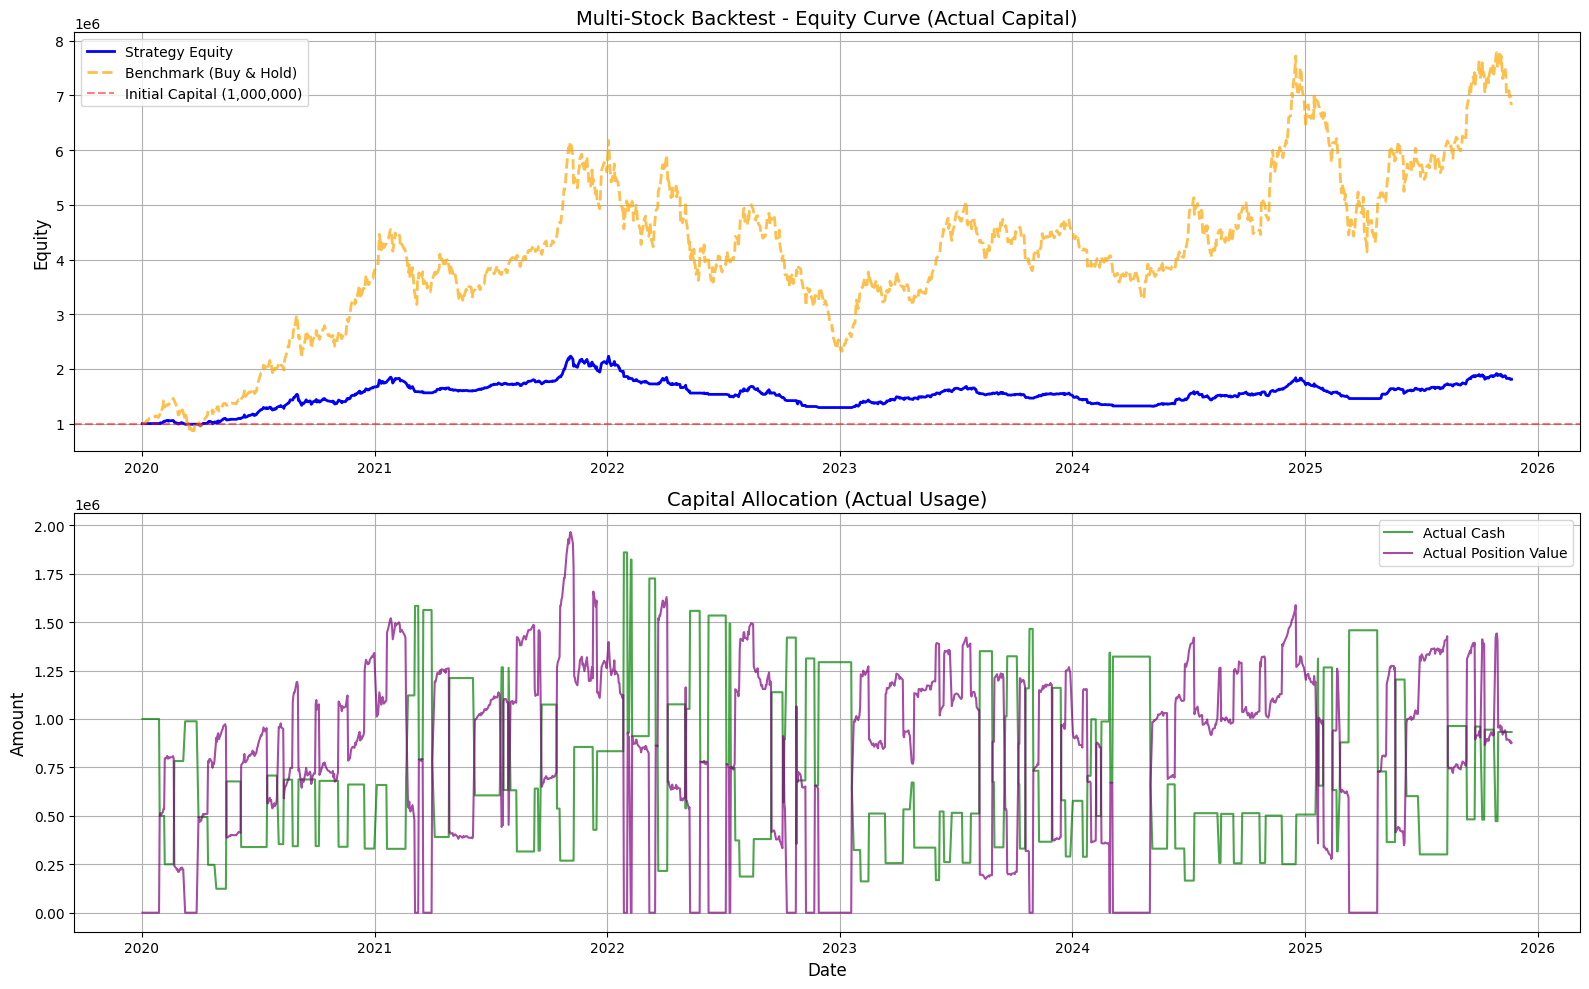

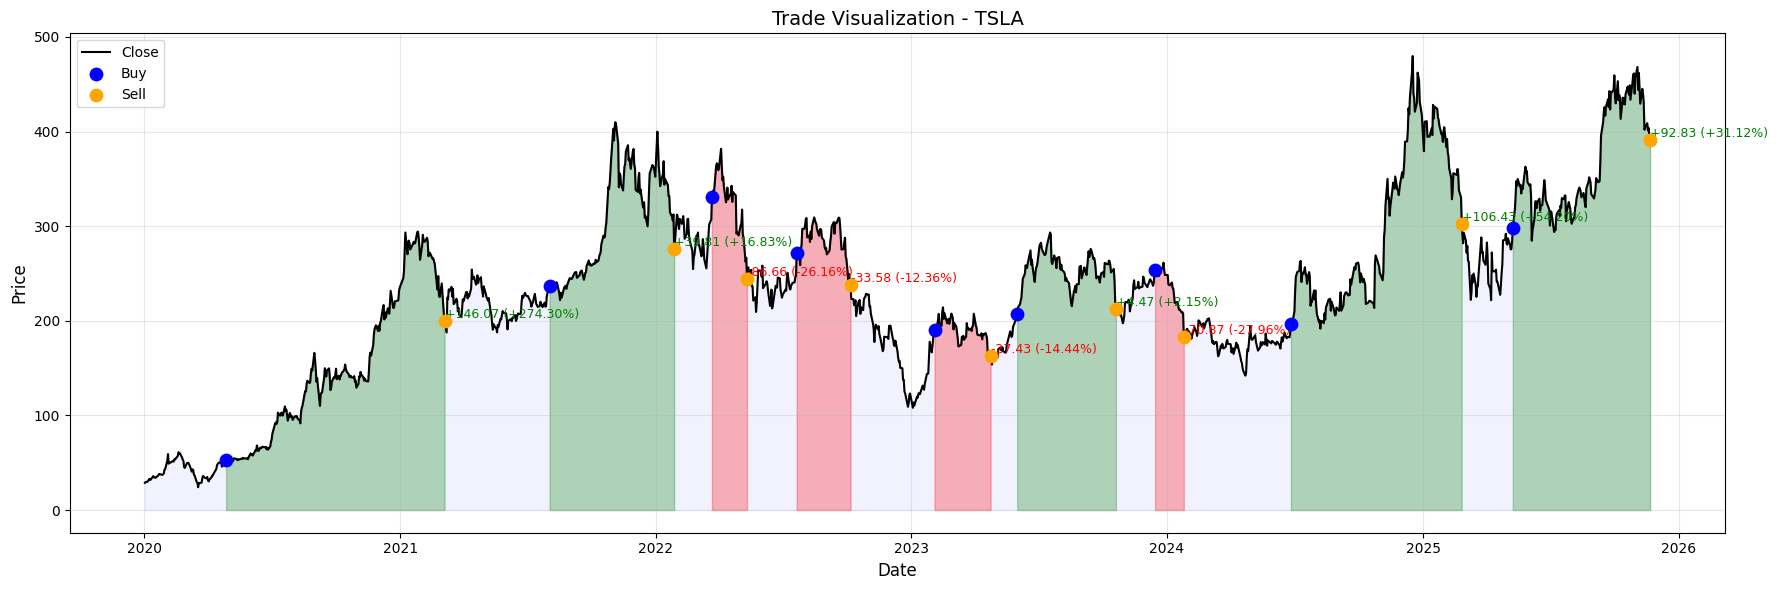

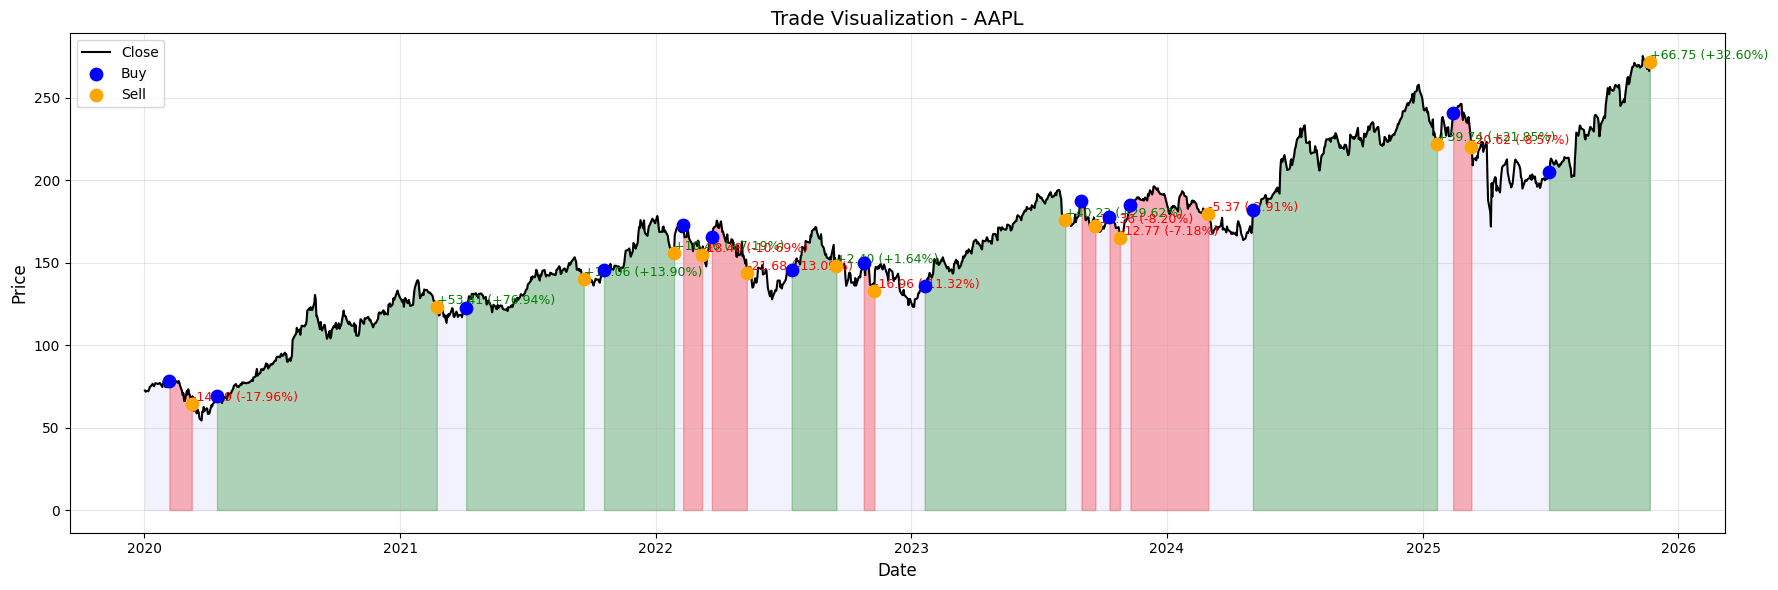

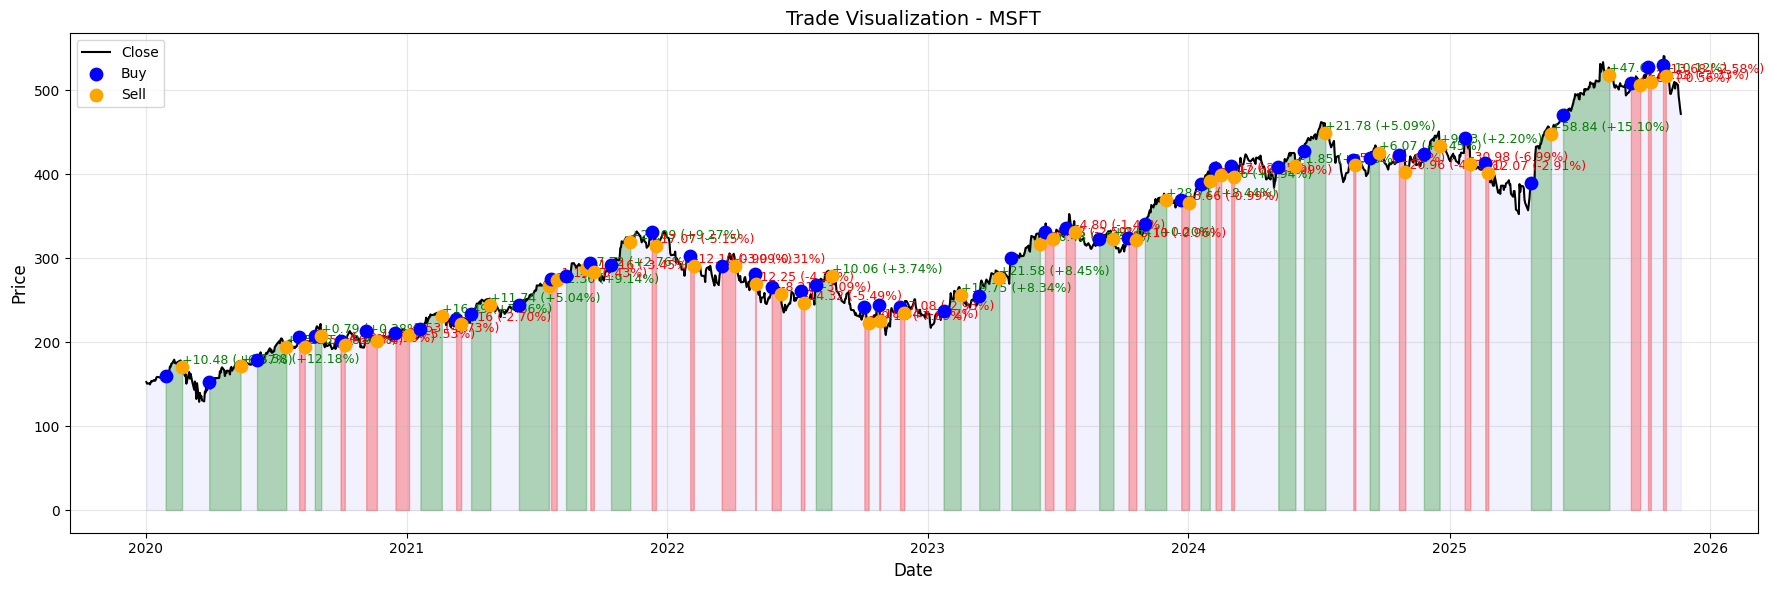


=== 績效指標 ===
策略_總報酬率: 0.8095
策略_年化報酬率: 0.1059
策略_年化波動率: 0.1834
策略_Sharpe: 0.6422
策略_最大回撤: -0.4210
策略_最終權益: 1809462.8248
策略_實際最終現金: 932586.3611
基準_總報酬率: 5.8255
基準_年化報酬率: 0.3855
基準_Sharpe: 0.6835
基準_最大回撤: -0.6238

總交易次數: 75

各股票交易次數:
symbol
AAPL    15
MSFT    51
TSLA     9
dtype: int64


In [9]:
# 範例6：多股票不同因子進行擇時
# 針對 TSLA 的策略
buy_factors_tsla = [{'xd': 42, 'class': BreakoutBuyFactor}]
sell_factors_tsla = [{'xd': 60, 'class': BreakdownSellFactor}]

# 針對 AAPL 的策略
buy_factors_aapl = [{'xd': 21, 'class': BreakoutBuyFactor}]
sell_factors_aapl = [{'xd': 42, 'class': BreakdownSellFactor}]

# 針對 MSFT 的策略
buy_factors_msft = [{'xd': 14, 'class': BreakoutBuyFactor}]
sell_factors_msft = [{'xd': 7, 'class': BreakdownSellFactor}]

# 建立客製化策略dict，股票用不同策略
factor_dict = {
    'TSLA': {
        'buy_factors': buy_factors_tsla,
        'sell_factors': sell_factors_tsla
    },
    'AAPL': {
        'buy_factors': buy_factors_aapl,
        'sell_factors': sell_factors_aapl
    },
    'MSFT': {
        'buy_factors': buy_factors_msft,
        'sell_factors': sell_factors_msft
    }
}

# 執行回測時，將 factor_dict 傳入 strategy_config
bt_multi_stock_strategy = MultiStockBacktester(
    stock_data=stock_data, 
    strategy_config=factor_dict, # 傳入客製化配置
    initial_capital=1_000_000,
    enable_full_rate_factor=False
)

results, trades, stats = bt_multi_stock_strategy.run(show_plot=True, show_trades_plot=True)

print("\n=== 績效指標 ===")
for k, v in stats.items():
    if isinstance(v, float):
        print(f"{k}: {v:.4f}")
    else:
        print(f"{k}: {v:,.0f}")

print(f"\n總交易次數: {len(trades)}")
print(f"\n各股票交易次數:")
print(trades.groupby('symbol').size())

In [10]:
# 透過交叉表驗證各股票是否都用各自的策略執行
pd.crosstab(trades.symbol, trades.buy_factor)

buy_factor,BreakoutBuyFactor_{'xd': 14};,BreakoutBuyFactor_{'xd': 21};,BreakoutBuyFactor_{'xd': 42};
symbol,,,
AAPL,0,15,0
MSFT,51,0,0
TSLA,0,0,9


Method 1: Display Full Summary
Performance Summary

[Basic Performance Metrics]
  Total Return        :     0.8095 ( 80.95%)
  Annual Return       :     0.1059 ( 10.59%)
  Annual Volatility   :     0.1834 ( 18.34%)
  Sharpe Ratio        :     0.6422 ( 64.22%)
  Max Drawdown        :    -0.4210 (-42.10%)
  Final Equity        : 1,809,462.82

[Trade Statistics]
  Total Trades        :         75
  Winning Trades      :         34
  Win Rate            :     0.4533 ( 45.33%)
  Profit/Loss Ratio   :       2.02
  Avg Profit          :  58,916.78
  Avg Loss            :  29,114.83
  Net Profit          : 809,462.82
  Max Single Profit   : 338,745.19
  Max Single Loss     : -162,234.53
  Avg Holding Days    :       49.8 days
  Avg Return          :     0.0583 (  5.83%)
  Max Consecutive Wins:          4
  Max Consecutive Losses:          9


Performance by Symbol


[TSLA]
  Total Trades: 9
  Winning: 5, Losing: 4
  Win Rate: 55.56%
  Total P&L: 307,427.32
  Avg Return: 33.08%
  Avg Holding Da

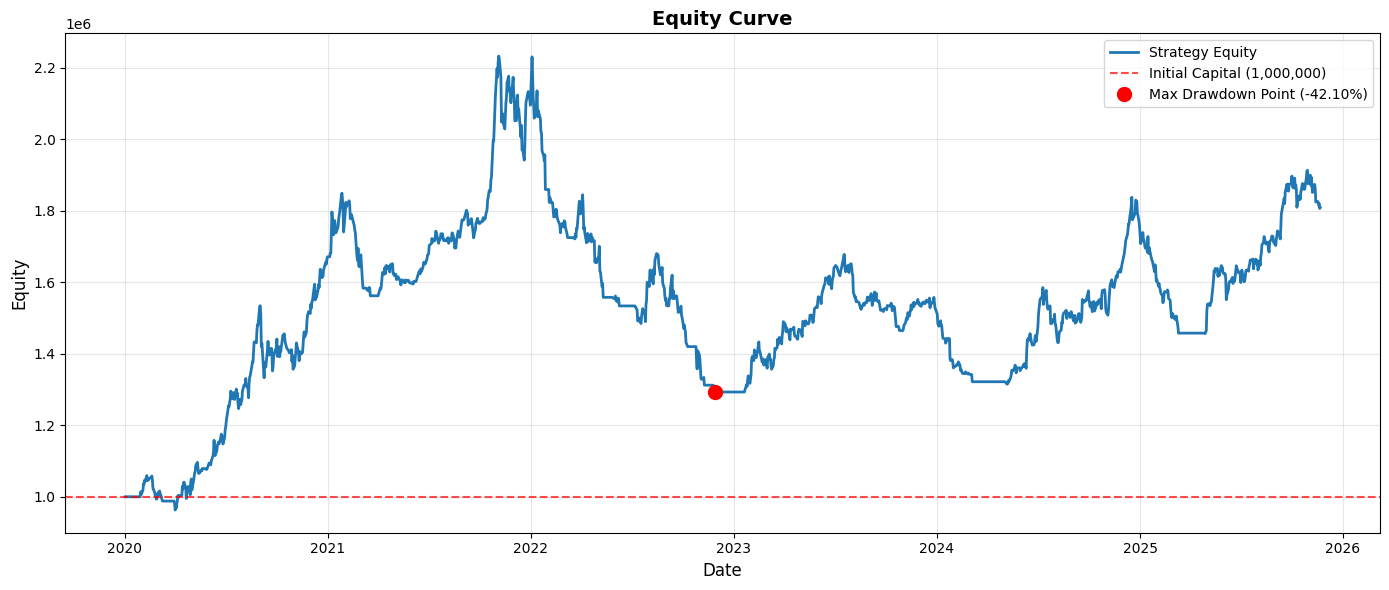


Plotting drawdown curve...


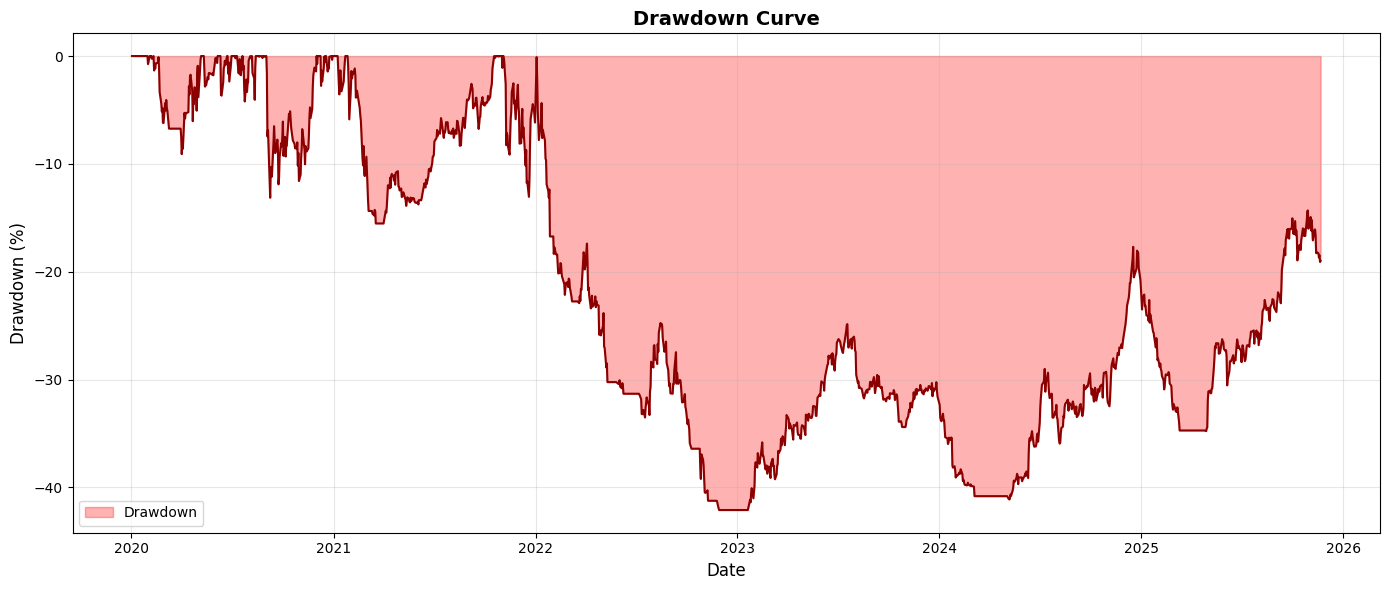


Plotting trade distribution...


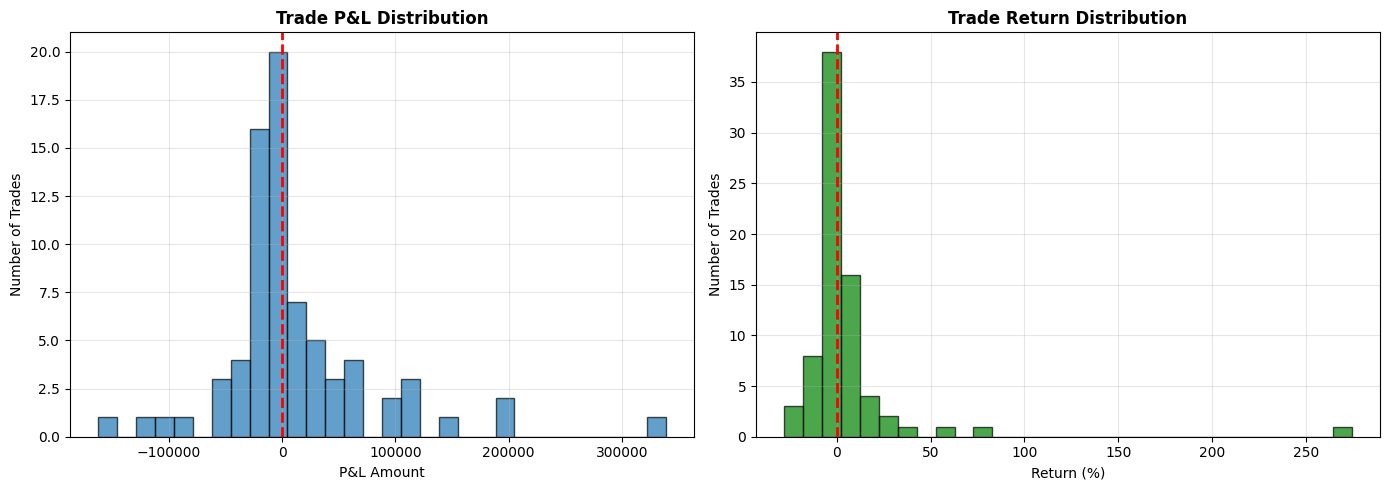


Plotting monthly returns...


/Users/alan/q-trade/alanq/performance/performance_metrics.py:462: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_equity = self.equity_curve.resample('M').last()


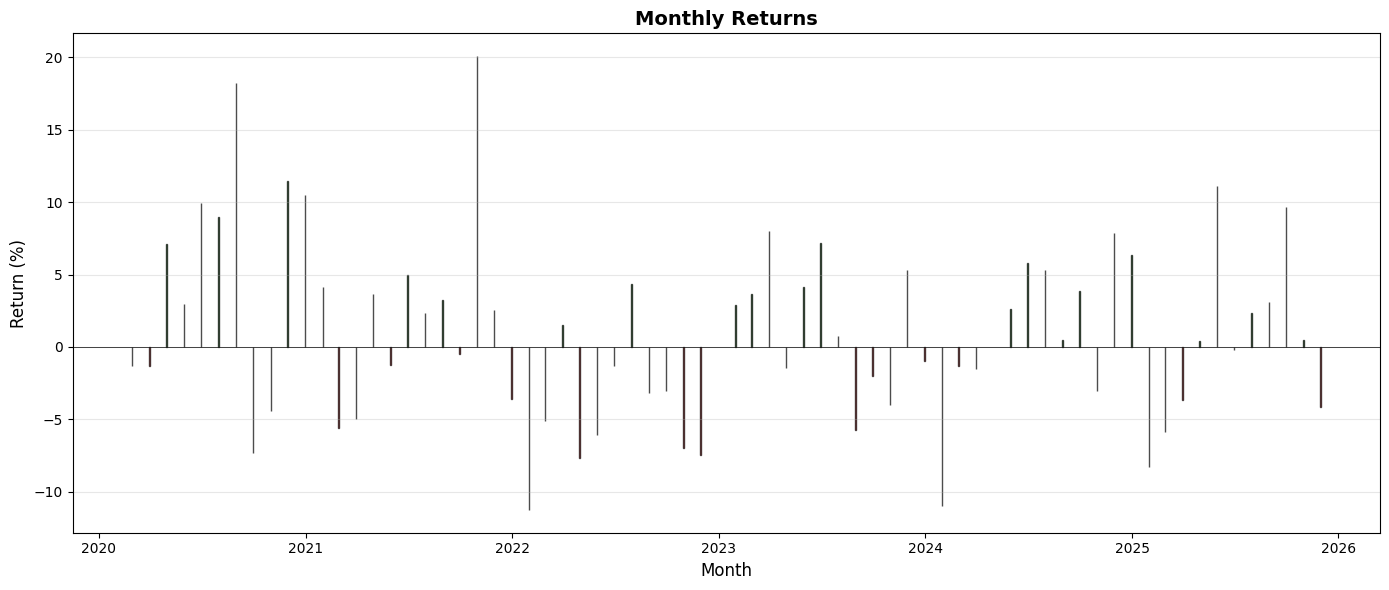


All metrics DataFrame:
                     數值
策略_總報酬率    8.094628e-01
策略_年化報酬率   1.059196e-01
策略_年化波動率   1.833721e-01
策略_Sharpe  6.421909e-01
策略_最大回撤   -4.209680e-01
策略_最終權益    1.809463e+06
總交易次數      7.500000e+01
獲利交易次數     3.400000e+01
勝率         4.533333e-01
盈虧比        2.023601e+00
平均獲利       5.891678e+04
平均虧損       2.911483e+04
淨獲利        8.094628e+05
最大單筆獲利     3.387452e+05
最大單筆虧損    -1.622345e+05
平均持倉天數     4.977333e+01
平均報酬率      5.832828e-02
最大連續獲利次數   4.000000e+00
最大連續虧損次數   9.000000e+00


In [11]:
# 使用範例：展示交易績效指標

# 使用之前的回測結果
# 建立績效指標物件
metrics = PerformanceMetrics(
    trades=trades,
    # stats=stats,
    equity_curve=results['equity_curve'],
    initial_capital=1_000_000
)

# 方法 1：顯示完整摘要
print("=" * 80)
print("Method 1: Display Full Summary")
print("=" * 80)
metrics.show_summary()

# 方法 2：按股票分組顯示
print("\n")
metrics.show_by_symbol()

# 方法 3：繪製各種圖表
print("\nPlotting equity curve...")
metrics.plot_equity_curve()

print("\nPlotting drawdown curve...")
metrics.plot_drawdown()

print("\nPlotting trade distribution...")
metrics.plot_trade_distribution()

print("\nPlotting monthly returns...")
metrics.plot_monthly_returns()

# 方法 4：取得所有指標的 DataFrame
print("\nAll metrics DataFrame:")
metrics_df = metrics.get_metrics_dataframe()
print(metrics_df)

# 方法 5：一次顯示所有內容（取消註解以執行）
# metrics.show_all()


In [12]:
# metrics_df 裡面預設的所有指標跟數值
metrics_df

,數值
策略_總報酬率,8.094628e-01
策略_年化報酬率,1.059196e-01
策略_年化波動率,1.833721e-01
策略_Sharpe,6.421909e-01
策略_最大回撤,-4.209680e-01
策略_最終權益,1.809463e+06
總交易次數,7.500000e+01
獲利交易次數,3.400000e+01
勝率,4.533333e-01
盈虧比,2.023601e+00


In [ ]:
"""
PerformanceMetrics 使用範例

展示如何使用類別化的指標系統
"""

import setup_path  # 設定 Python 路徑以引用 alanq 模組
from alanq.performance import (
    PerformanceMetrics,
    # 基本指標
    TotalReturnMetric,
    SharpeMetric,
    MaxDrawdownMetric,
    # 詳細指標
    BasicTradeStatsMetric,
    WinRateMetric,
)

# =========================================================
# 範例 1：使用預設指標組合（完全向後相容）
# =========================================================
def example_default_metrics():
    """
    使用預設指標組合，行為與之前完全相同
    """
    # 假設您已經有回測結果
    # results, trades, stats = backtester.run()
    
    # 使用預設指標（不傳入 basic_metrics 和 detailed_metrics）
    metrics_by_performance_metrics = PerformanceMetrics(
        trades=trades,
        equity_curve=results['equity_curve'],
        initial_capital=1_000_000
    )
    
    # 或傳入 stats（由backtester計算的，不建議使用）
    metrics_by_backtester = PerformanceMetrics(
        trades=trades,
        stats=stats,
        equity_curve=results['equity_curve'],
        initial_capital=1_000_000
    )
    
    return metrics_by_performance_metrics, metrics_by_backtester


# =========================================================
# 範例 2：使用自訂指標組合
# =========================================================
def example_custom_metrics():
    """
    只計算特定的指標
    """
    # 假設您已經有回測結果
    # results, trades, stats = backtester.run()
    
    # 只計算總報酬率、Sharpe 和最大回撤
    basic_metrics = [
        {"class": TotalReturnMetric},
        {"class": SharpeMetric},
        {"class": MaxDrawdownMetric},
    ]
    
    # 只計算基本交易統計和勝率
    detailed_metrics = [
        {"class": BasicTradeStatsMetric},
        {"class": WinRateMetric},
    ]
    
    metrics_custom = PerformanceMetrics(
        trades=trades,
        equity_curve=results['equity_curve'],
        initial_capital=1_000_000,
        basic_metrics=basic_metrics,
        detailed_metrics=detailed_metrics
    )
    
    return metrics_custom


# =========================================================
# 範例 3：創建自訂指標類別
# =========================================================
def example_custom_metric_class():
    """
    創建自訂指標類別
    """
    from alanq.performance.basic import BaseBasicMetric
    import numpy as np
    import pandas as pd
    from typing import Dict
    
    class SortinoRatioMetric(BaseBasicMetric):
        """
        自訂的 Sortino Ratio 指標（只考慮下行波動率）
        """
        
        def __init__(self, risk_free_rate=0.0, **kwargs):
            super().__init__(**kwargs)
            self.risk_free_rate = risk_free_rate
            # 覆寫指標名稱
            self.metric_name = "策略_Sortino"
        
        def calculate(self, equity_curve: pd.Series, 
                      initial_capital: float,
                      existing_stats: Dict[str, float]) -> Dict[str, float]:
            """計算 Sortino Ratio"""
            if equity_curve is None or equity_curve.empty:
                return {self.metric_name: np.nan}
            
            daily_returns = equity_curve.pct_change().dropna()
            downside_returns = daily_returns[daily_returns < 0]
            
            if len(downside_returns) > 1 and downside_returns.std() > 0:
                downside_vol = downside_returns.std() * np.sqrt(252)
                annual_return = existing_stats.get("策略_年化報酬率", np.nan)
                
                if not np.isnan(annual_return) and downside_vol > 0:
                    sortino = (annual_return - self.risk_free_rate) / downside_vol
                else:
                    sortino = np.nan
            else:
                sortino = np.nan
            
            return {self.metric_name: sortino}
    from alanq.performance.basic import AnnualReturnMetric
    # 使用自訂指標
    basic_metrics = [
        {"class": TotalReturnMetric},
        {"class": AnnualReturnMetric},
        {"class": SortinoRatioMetric, "risk_free_rate": 0.02},  # 可以傳入參數
    ]
    
    metrics = PerformanceMetrics(
        trades=trades,
        equity_curve=results['equity_curve'],
        initial_capital=1_000_000,
        basic_metrics=basic_metrics
    )
    return metrics



df = example_custom_metrics().get_metrics_dataframe()
df

,數值
策略_總報酬率,0.809463
策略_Sharpe,0.642191
策略_最大回撤,-0.420968
總交易次數,75.000000
獲利交易次數,34.000000
虧損交易次數,41.000000
持平交易次數,0.000000
勝率,0.453333
